In [1]:
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the final EURUSD labeled dataset
data_path = '../../data/eurusd_h1_labeled.csv'
df = pd.read_csv(data_path, index_col='time', parse_dates=True)

df.dropna(inplace=True)

print("EURUSD labeled data loaded successfully.")
print(f"Data shape: {df.shape}")

EURUSD labeled data loaded successfully.
Data shape: (35197, 31)


In [2]:
# --- Prepare Data for Training ---
# Define our features (X) and target (y)
features = [col for col in df.columns if col not in ['open', 'high', 'low', 'close', 'volume', 'target']]
X = df[features]
y = df['target']

# Split the data chronologically
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Data split into training and testing sets.")

# --- Calculate class weights to handle imbalance ---
class_counts = y_train.value_counts()
weight_for_hold = (class_counts.get(1, 0) + class_counts.get(-1, 0)) / class_counts.get(0, 1)
print(f"Calculated weight for HOLD class: {weight_for_hold:.2f}")

# Create a weight array for each sample in the training set
sample_weights = y_train.apply(lambda x: weight_for_hold if x == 0 else 1)

# --- Initialize the XGBoost Classifier with the BEST parameters for EURUSD ---
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    # --- PLUG IN THE BEST PARAMETERS FROM YOUR NOTEBOOK 7 ---
    colsample_bytree=0.9,
    gamma=5,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=500,
    reg_lambda=5,
    subsample=0.7
)

print("\nModel initialized with the best parameters found.")

# Map target labels for the model
y_train_mapped = y_train.replace({-1: 2})
y_test_mapped = y_test.replace({-1: 2})

# --- Train the Final Model ---
print("\nTraining the final EURUSD model with sample weights...")
model.fit(X_train, y_train_mapped, sample_weight=sample_weights.values)
print("Model training complete.")

Data split into training and testing sets.
Calculated weight for HOLD class: 3.53

Model initialized with the best parameters found.

Training the final EURUSD model with sample weights...


c:\Users\aliefchandrawijaya\Documents\forex_bot\venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model training complete.


Model outputted final predictions directly.

--- Final EURUSD Model Performance ---
              precision    recall  f1-score   support

          -1       0.64      0.24      0.35      2639
           0       0.26      0.77      0.39      1655
           1       0.67      0.29      0.40      2746

    accuracy                           0.38      7040
   macro avg       0.52      0.43      0.38      7040
weighted avg       0.56      0.38      0.38      7040


Confusion Matrix:


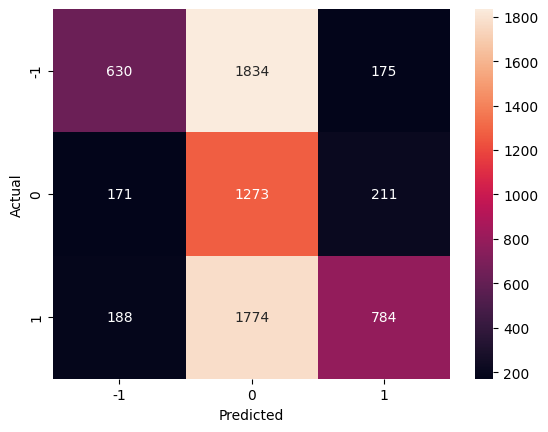

In [3]:
# In Notebook EURUSD-3 -- The FINAL, Corrected Cell 3

# Make predictions on the test data
y_pred_output = model.predict(X_test)

# --- THIS IS THE CRITICAL FIX ---
# Check if the model's output is 2D (probabilities) or 1D (final predictions)
if y_pred_output.ndim > 1:
    # If it's 2D, it's the probabilities. We find the class with the highest probability.
    print("Model outputted probabilities. Finding max...")
    y_pred_mapped = y_pred_output.argmax(axis=1)
else:
    # If it's already 1D, the model gave us the final class predictions directly.
    print("Model outputted final predictions directly.")
    y_pred_mapped = y_pred_output
# ----------------------------

# Map the predictions back from 2 to -1 to make the report readable
y_pred = pd.Series(y_pred_mapped).replace({2: -1}).values

# Print the final classification report
print("\n--- Final EURUSD Model Performance ---")
print(classification_report(y_test, y_pred, zero_division=0))

# Display the final confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [4]:
# Save the trained model to the 'models' directory
model_path = '../../models/eurusd_h1.pkl'
joblib.dump(model, model_path)

print(f"\nSUCCESS: Final EURUSD model saved successfully to: '{model_path}'")


SUCCESS: Final EURUSD model saved successfully to: '../../models/eurusd_h1.pkl'
